In [1]:
import os
import sys

sys.path.append('../')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import gridspec
from matplotlib.colors import Normalize
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from kwave.ktransducer import kWaveGrid
from models.DAS import DAS
from models.PACT import Joint_Recon, get_mgrid
from utils.data import *
from utils.reconstruction import *
from utils.simulations import get_water_SoS
from utils.visualization import *

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '../data/'
results_path = '../results/'

In [2]:
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation.mat'))

SoS = load_mat(os.path.join(data_path, 'SoS.mat'))
SoS_SB = load_mat(os.path.join(data_path, 'SoS_SB.mat'))
SoS_body = load_mat(os.path.join(data_path, 'SoS_body.mat'))

In [3]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec
l = 3.2e-3 # Patch size [m].

In [4]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_SoS(T)   # Background SoS [m/s].
v1 = 1567.3             # Avergae SoS in single body [m/s].
print(v0, v1)

1499.3632858457756 1567.3


In [5]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = torch.tensor(gaussian_kernel(sigma, 80), device=device)

In [6]:
das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero', device=device)
das.to(device)
das.eval()

DAS()

In [7]:
n_delays = 32
delays = np.linspace(-10e-4, 6e-4, n_delays)

In [8]:
img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays):
        recon = das(sinogram=torch.tensor(sinogram, device=device), 
                    v0=torch.tensor(v0, device=device),
                    d_delay=torch.tensor(d_delay, device=device),
                    ring_error=torch.zeros(1, device=device))
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0)

100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


In [9]:
# from models.SIREN import SIREN

# n_iters = 1000
# lr = 1e-4

# siren = SIREN(num_hidden_layers=2, activation_fn='sin', in_features=2, hidden_features=128, out_features=1)
# siren.cuda()

# optim = Adam(lr=lr, params=siren.parameters())

mask = torch.zeros((560, 560))
XX, YY = torch.meshgrid(torch.tensor(x_vec[:,0]), torch.tensor(y_vec[:,0]))
mask[XX**2 + YY**2 <= R**2] = 1
# coords = get_mgrid(mask.shape, range=(-1, 1)).to(device)
# coords = coords[mask.view(-1)>0]
        
        
# for step in range(1, n_iters+1):
#     output, _ = siren(coords)  
#     loss = ((output-1) ** 2).mean()
    
#     if not step % 100:
#         print("Step %d, Total loss %0.6f" % (step, loss))

#     optim.zero_grad()
#     loss.backward()
#     optim.step()

# torch.save(siren.state_dict(), 'siren.pth')

/home/tianao/anaconda3/envs/pact/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
SoS[mask>0].mean(), SoS[mask>0].std()

(1592.1555871418043, 160.96378370599504)

In [11]:
class JR_Dataset(Dataset):
    def __init__(self, img_stack, l):
        img_stack = img_stack
        l = l

    def __len__(self):
        return 625
    
    def __getitem__(self, idx):
        i, j = idx // 25, idx % 25
        x, y = (j-12)*l / 4, (12-i)*l / 4
        return torch.tensor(x), torch.tensor(y), img_stack[:,20*i:20*i+80, 20*j:20*j+80]
    
dataset = JR_Dataset(img_stack, l)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [12]:
joint_recon = Joint_Recon(SoS=SoS_body, x_vec=x_vec, y_vec=y_vec, R=R, v0=v0, n_points=80, l=3.2e-3, n_delays=n_delays, angle_range=(0, 2*torch.pi), 
                          lam_tv=1.e-9, lam_l1=1.e-9, device=device)
joint_recon.to(device)
total = sum([param.nelement() for param in joint_recon.parameters()])
print("Number of parameter: %s" % (total))

optimizer = Adam(params=joint_recon.parameters(), lr=1e-5)

Number of parameter: 33537


In [13]:
n_epochs = 200
loss_list = []
for epoch in range(n_epochs):
    joint_recon.train()
    train_loss = 0
    for idx, (x, y, img) in enumerate(data_loader):
        x, y, img = x.to(device), y.to(device), img.to(device)
        optimizer.zero_grad()
        rec_jr, SoS_jr, loss = joint_recon(x, y, img, torch.tensor(delays, device=device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    loss_list.append(train_loss)
    print((" [{}/{}]  loss={:.4g} ".format(epoch+1, n_epochs, train_loss/len(data_loader))))

/home/tianao/PACT/notebooks/../models/PACT.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas, wfs = self.wavefront_sos(torch.tensor(x), torch.tensor(y), SoS)


 [1/200]  loss=0.02956 
 [2/200]  loss=0.02866 
 [3/200]  loss=0.02823 
 [4/200]  loss=0.02807 
 [5/200]  loss=0.02798 
 [6/200]  loss=0.02786 
 [7/200]  loss=0.02778 
 [8/200]  loss=0.02771 
 [9/200]  loss=0.02765 
 [10/200]  loss=0.02761 
 [11/200]  loss=0.02756 
 [12/200]  loss=0.02752 
 [13/200]  loss=0.02747 
 [14/200]  loss=0.02741 
 [15/200]  loss=0.02736 
 [16/200]  loss=0.02727 
 [17/200]  loss=0.02722 
 [18/200]  loss=0.02721 
 [19/200]  loss=0.02718 
 [20/200]  loss=0.02715 
 [21/200]  loss=0.02714 
 [22/200]  loss=0.02713 
 [23/200]  loss=0.02711 
 [24/200]  loss=0.02711 
 [25/200]  loss=0.02711 
 [26/200]  loss=0.0271 
 [27/200]  loss=0.02709 
 [28/200]  loss=0.02709 
 [29/200]  loss=0.02708 
 [30/200]  loss=0.02708 
 [31/200]  loss=0.02707 
 [32/200]  loss=0.02707 
 [33/200]  loss=0.02707 
 [34/200]  loss=0.02706 
 [35/200]  loss=0.02707 
 [36/200]  loss=0.02706 
 [37/200]  loss=0.02706 
 [38/200]  loss=0.02706 
 [39/200]  loss=0.02707 
 [40/200]  loss=0.02705 
 [41/200] 

KeyboardInterrupt: 

In [14]:
SoS_jr = SoS_jr.squeeze(0).squeeze(0).detach().cpu().numpy()
rec_jr = rec_jr.squeeze(0).squeeze(0).detach().cpu().numpy()

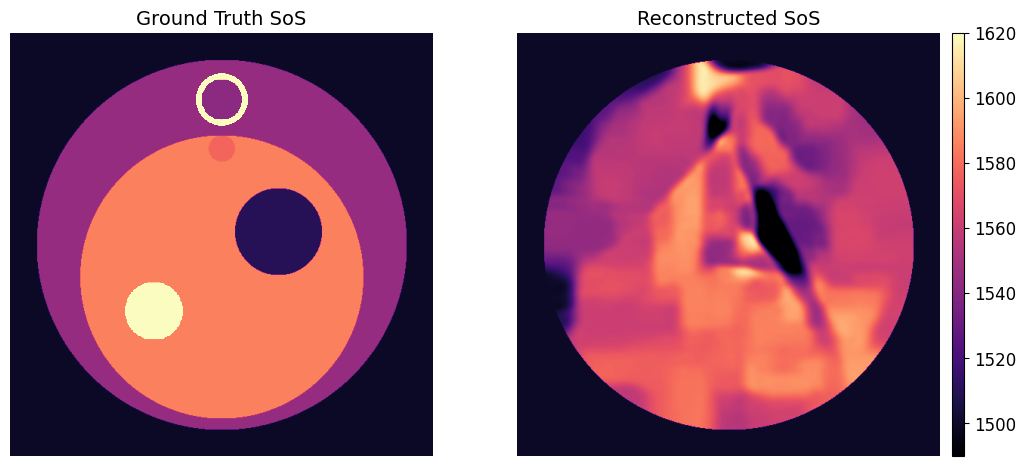

In [18]:
fig = plt.figure(figsize=(12, 6))
norm = Normalize(vmax=1620, vmin=1490)

ax = plt.subplot(1, 2, 1)
plt.title('Ground Truth SoS', fontsize=14)
plt.imshow(SoS, norm=norm, cmap='magma')
plt.axis('off')

ax = plt.subplot(1, 2, 2)
plt.title('Reconstructed SoS', fontsize=14)
plt.imshow(SoS_jr, norm=norm, cmap='magma')
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.01, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
# cb.ax.set_yticks([1500, 1520, 1540, 1560, 1580, 1600])
cb.ax.tick_params(labelsize=12)

In [16]:
SoS_jr.min()

1468.3182352781296

In [17]:
save_mat(os.path.join(results_path, 'SoS_jr.mat'), SoS_jr.swapaxes(0,1), 'SoS')